# Custom priors

In this notebook, we demonstrate how to define custom parameter priors.

In [1]:
import numpy as np

from pyabc import *

rng = np.random.default_rng()

We consider a simple 2-dimensional test problem with four posterior modes:

In [2]:
# noise standard deviation
std = 0.2


def model(p):
    """Quadratic model with two in- and outputs."""
    return {
        "y0": p["p0"] ** 2 + std * rng.normal(),
        "y1": p["p1"] ** 2 + std * rng.normal(),
    }


# ABC distance function
distance = PNormDistance(p=2)

# ground truth parameters
gt_par = {"p0": 1, "p1": 1.2}

# observed data
obs = model(gt_par)

# ABC population size and maximum evaluations
pop_size = 1000
max_total_sim = 50 * pop_size

# parameter boundaries
prior_bounds = {"p0": (-2, 2), "p1": (-2, 2)}

In most pyABC examples and applications, we have independent parameter priors, which can be expressed in pyABC simply via a `Distribution` which assumes independency of passed one-dimensional priors:

In [3]:
prior = Distribution(
    p0=RV("uniform", -2, 4),
    p1=RV("uniform", -2, 4),
)

If we use this prior, we find that the posterior exhibits four distinct modes:

In [4]:
# standard pyABC workflow
abc = ABCSMC(model, prior, distance, population_size=pop_size)
abc.new(create_sqlite_db_id(), obs)
h = abc.run(max_total_nr_simulations=max_total_sim)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=4, start_time=2022-04-04 16:54:41>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.49234810e+00.
ABC INFO: Accepted: 1000 / 2007 = 4.9826e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.10051564e+00.
ABC INFO: Accepted: 1000 / 2618 = 3.8197e-01, ESS: 9.6474e+02.
ABC INFO: t: 2, eps: 8.41417921e-01.
ABC INFO: Accepted: 1000 / 3349 = 2.9860e-01, ESS: 9.5689e+02.
ABC INFO: t: 3, eps: 6.29025180e-01.
ABC INFO: Accepted: 1000 / 4853 = 2.0606e-01, ESS: 9.4498e+02.
ABC INFO: t: 4, eps: 4.65501309e-01.
ABC INFO: Accepted: 1000 / 7645 = 1.3080e-01, ESS: 9.7925e+02.
ABC INFO: t: 5, eps: 3.31555988e-01.
ABC INFO: Accepted: 1000 / 12925 = 7.7369e-02, ESS: 9.8705e+02.
ABC INFO: t: 6, eps: 2.39407788e-01.
ABC INFO: Accepted: 1000 / 24502 = 4.0813e-02, ESS: 9.8812e+02.
ABC INFO: Stop: Total simulations budget.
ABC.History INFO: Done <ABCSMC id=4, duration=0:00:36.329396, end_time=2022-04-04 16:55:17>


ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.05}


array([[<AxesSubplot:ylabel='p0'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='p0', ylabel='p1'>,
        <AxesSubplot:xlabel='p1'>]], dtype=object)

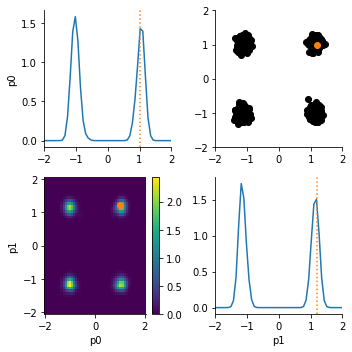

In [5]:
# 1+2 dim marginal matrix plot via kernel density estimates
visualization.plot_kde_matrix_highlevel(
    h,
    limits=prior_bounds,
    refval=gt_par,
    kde=GridSearchCV(),
)

Now let us assume that we know that the sum of parameters should actually be greater than 1.0. We can encode this by formulating a custom prior derived from the `DistributionBase` class. We need to implement a `rvs()` method that generates (pseudo) random samples from the distribution (here via rejection sampling), and a `pdf()` method that evaluates the density for a given parameter. The density need not be normalized.

In [6]:
class ConstrainedPrior(DistributionBase):
    def __init__(self):
        self.p0 = RV("uniform", -2, 4)
        self.p1 = RV("uniform", -2, 4)
        self.min_sum: float = 1.0

    def rvs(self, *args, **kwargs):
        while True:
            p0, p1 = self.p0.rvs(), self.p1.rvs()
            if p0 + p1 > self.min_sum:
                return Parameter(p0=p0, p1=p1)

    def pdf(self, x):
        p0, p1 = x["p0"], x["p1"]
        if p0 + p1 <= self.min_sum:
            return 0.0
        return self.p0.pdf(p0) * self.p1.pdf(p1)


constrained_prior = ConstrainedPrior()

As expected, now only the upper right posterior mode is sampled.

In [7]:
# standard pyABC workflow
abc = ABCSMC(model, constrained_prior, distance, population_size=pop_size)
abc.new(create_sqlite_db_id(), obs)
h = abc.run(max_total_nr_simulations=max_total_sim)

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=5, start_time=2022-04-04 16:55:21>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.57795072e+00.
ABC INFO: Accepted: 1000 / 1928 = 5.1867e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.14261527e+00.
ABC INFO: Accepted: 1000 / 2073 = 4.8239e-01, ESS: 9.6627e+02.
ABC INFO: t: 2, eps: 8.62637704e-01.
ABC INFO: Accepted: 1000 / 2437 = 4.1034e-01, ESS: 9.4258e+02.
ABC INFO: t: 3, eps: 6.21836300e-01.
ABC INFO: Accepted: 1000 / 2536 = 3.9432e-01, ESS: 8.8251e+02.
ABC INFO: t: 4, eps: 4.60224825e-01.
ABC INFO: Accepted: 1000 / 2651 = 3.7722e-01, ESS: 5.7476e+02.
ABC INFO: t: 5, eps: 3.33140306e-01.
ABC INFO: Accepted: 1000 / 3535 = 2.8289e-01, ESS: 7.6206e+02.
ABC INFO: t: 6, eps: 2.35619085e-01.
ABC INFO: Accepted: 1000 / 4980 = 2.0080e-01, ESS: 6.2725e+02.
ABC INFO: t: 7, eps: 1.70215801e-01.
ABC INFO: Accepted: 1000 / 7465 = 1.3396e-01, ESS: 5.8647e+02.
ABC INFO: t: 8, eps: 1.21842793e-01.
A

ABC.Transition INFO: Best params: {'scaling': 1.0}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 1.0}


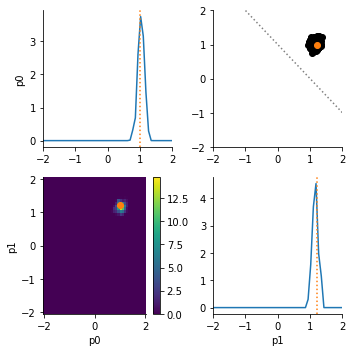

In [8]:
# 1+2 dim marginal matrix plot via kernel density estimates
arr_ax = visualization.plot_kde_matrix_highlevel(
    h,
    limits=prior_bounds,
    refval=gt_par,
    kde=GridSearchCV(),
)
arr_ax[0][1].plot([-2, 2], [3, -1], linestyle="dotted", color="grey")